In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bisect

In [2]:
from transformers import BertTokenizer
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
# Constants
RECORD_PATH = "C:\\Users\\NGUYEMI\\Work\\data\\documents.json"
DATA_PATH = "C:\\Users\\NGUYEMI\\Work\\data\\gt\\"
UNK_TOKEN = 100

In [4]:
### Functions

In [5]:
def get_record():
    """Read the document record file"""
    record_file = open(RECORD_PATH, "r", encoding="utf8")
    record = json.load(record_file)
    return record

In [6]:
record = get_record()

In [7]:
def check_record(record=get_record()):
    """Check if the number of documents in the record matches the number of data files"""
    assert len(record) == len(os.listdir(DATA_PATH))

In [8]:
# check_record()

In [9]:
def get_doc(document_name):
    """Given a name, return the corresponding document"""
    return json.load(open(DATA_PATH + document_name + ".json", "r", encoding="utf8"))

In [10]:
def check_doc(document_name):
    """Check if extracted sentences and words have correct location tags
    Check if relations contain exactly 2 arguments
    """
    doc = get_doc(document_name)
    for sentence in doc["sentences"]:
        try:
            assert sentence["text"] == doc["text"][sentence["begin"] : sentence["end"]]
        except:
            print("Error in doc", document_name, "sentence", sentence["id"], "'", sentence["text"], "' does not match '", doc["text"][sentence["begin"] : sentence["end"]])
        for word in sentence["tokens"]:
            try:
                assert word["text"] == doc["text"][word["begin"] : word["end"]]
            except:
                print("Error in doc", document_name, "sentence", sentence["id"], "word", word["id"], "'", word["text"], "' does not match '", doc["text"][word["begin"] : word["end"]])
    for relation in doc["relations"]:
        try:
            assert len(relation["args"]) == 2
        except:
            print("Error in doc", document_name, "relation", relation["id"], "has", len(relation["args"]), "arguments")

In [11]:
def check_data(record=get_record()):
    """Check if the dataset is in good shape
    Refer to check_record() and check_doc()
    """
    check_record(record)
    for document in record:
        check_doc(document["id"])

In [12]:
check_data()

In [13]:
def get_text_length_doc(document_name):
    """Get text length and sentence length of a document"""
    text_length = 0
    sentence_lengths = []
    doc = get_doc(document_name)
    for sentence in doc["sentences"]: 
        text_length += len(sentence["tokens"])
        sentence_lengths.append(len(sentence["tokens"]))
    return text_length, sentence_lengths

In [14]:
def describe_list(lst, name):
    """Show the properties of the given sequence"""
    print("Description of", name, ":")
    print("Count:", len(lst))
    print("Sum:", sum(lst))
    print("Min:", min(lst))
    print("Mean:", sum(lst) / len(lst))
    print("Max:", max(lst))
    sns.distplot(lst, axlabel=name)
    plt.show()
    print()

In [15]:
def describe_text_length(record=get_record()):
    """Show information about the length of text and sentences in the dataset"""
    text_lengths = []
    sentence_lengths = []
    for document in record:
        txt_len, snt_len = get_text_length_doc(document["id"])
        text_lengths.append(txt_len)
        sentence_lengths += snt_len
    describe_list(text_lengths, "Text length")
    describe_list(sentence_lengths, "Sentence length")

In [16]:
# describe_text_length()

In [17]:
def count_type_doc(document_name, type_name):
    """Count the number of each type of a property in a document"""
    doc = get_doc(document_name)
    count = {}
    for item in doc[type_name]: 
        if item["type"] not in count:
            count[item["type"]] = 1
        else:
            count[item["type"]] += 1
    return count

In [18]:
def describe_type(type_name, record=get_record(), describe=True):
    """Describe the types of a property in the dataset"""
    count = {}
    for document in record:
        cnt = count_type_doc(document["id"], type_name)
        for key in cnt:
            if key not in count:
                count[key] = cnt[key]
            else:
                count[key] += cnt[key]
    if describe:
        print("Description of", type_name)
        print("Total:", sum(count.values()))
        for key in count:
            print(key, ":", count[key])
        sns.barplot(list(count.values()), list(count.keys()))
        plt.show()
    # Return a map from entities to corresponding encoding numbers
    return dict(zip(["None"] + list(count.keys()), range(len(count) + 1)))

In [19]:
entity_encode = describe_type("mentions", describe=False)

In [20]:
# entity_encode

In [21]:
relation_encode = describe_type("relations", describe=False)

In [22]:
# relation_encode

In [23]:
def get_word_doc(document_name):
    """Extract words and their position from a document"""
    doc = get_doc(document_name)
    words = []
    begins = []
    ends = []
    sentence_embedding = []
    sentence_count = 0
    for sentence in doc["sentences"]:
        for word in sentence["tokens"]:
            # Put words to lower case to use uncased bert model
            words.append(word["text"].lower())
            begins.append(word["begin"])
            ends.append(word["end"])
            sentence_embedding.append(sentence_count)
        sentence_count += 1
    return words, begins, ends, sentence_embedding

In [24]:
def get_token_id(words):
    """Tokenize each word in a list of words
    Return a list of lists of token ids
    """
    token_id = []
    for word in words:
        # apply [1:-1] to remore CLS and SEP token ids at the begin and the end of the list
        token_id.append(tokenizer(word)["input_ids"][1:-1])
    return token_id

In [25]:
def expand_token_id(token_id, words, begins, ends, sentence_embedding):
    """Expand token id and duplicate members in other list wherever necessary"""
    # Test if all lists have the same length as expected
    try:
        assert len(token_id) == len(words) == len(begins) == len(ends) == len(sentence_embedding)
    except:
        print("Input lists do not have the same length, abort")
        return token_id, words, begins, ends, sentence_embedding
    new_token_id = []
    new_words = []
    new_begins = []
    new_ends = []
    new_sentence_embedding = []
    for i in range(len(token_id)):
        for tid in token_id[i]:
            new_token_id.append(tid)
            new_words.append(words[i])
            new_begins.append(begins[i])
            new_ends.append(ends[i])
            new_sentence_embedding.append(sentence_embedding[i])
    return new_token_id, new_words, new_begins, new_ends, new_sentence_embedding

In [26]:
def get_entity_doc(document_name, begins):
    """Extract entities from a document (only use AFTER token id has been expanded)"""
    doc = get_doc(document_name) 
    entity_embedding = [0] * len(begins)
    entity_position = {}
    for mention in doc["mentions"]:
        low = bisect.bisect_left(begins, mention["begin"])
        high = bisect.bisect_left(begins, mention["end"])
        entity_position[mention["id"]] = (low, high)
        for i in range(low, high):
            entity_embedding[i] = entity_encode[mention["type"]]      
    return entity_position, entity_embedding

In [27]:
def get_relation_doc(document_name, entity_position):
    """Extract relations from a document"""
    doc = get_doc(document_name)
    relation_position = {}
    for relation in doc["relations"]:
        relation_position[relation["id"]] = tuple(relation["args"])
    return relation_position

In [28]:
### TEST
test_doc = record[0]["id"]
# print("The first document is:", test_doc)
assert test_doc == "143f9e00-34c4-11eb-a28a-8b07c9b15060-0"

test_words, test_begins, test_ends, test_sentence_embedding = get_word_doc(test_doc)
test_token_ids = get_token_id(test_words)
# print("Words:", test_words)
# print("Token ids:", test_token_ids)

test_token_ids, test_words, test_begins, test_ends, test_sentence_embedding = \
    expand_token_id(test_token_ids, test_words, test_begins, test_ends, test_sentence_embedding)
# print("Expanded words:", test_words)
# print("Expanded token ids:", test_token_ids)

test_entity_position, test_entity_embedding = get_entity_doc(test_doc, test_begins)
# print("Entity embedding:", test_entity_embedding)

# print("Entity tokens:")
# for low, high in test_entity_position.values():
#     print(test_words[low:high], test_token_ids[low:high], test_entity_embedding[low:high])
    
test_relation_position = get_relation_doc(test_doc, test_entity_position)
# print("Relation position:", test_relation_position)

In [29]:
### TEST
assert len(test_words) \
    == len(test_token_ids) \
    == len(test_begins) \
    == len(test_ends) \
    == len(test_sentence_embedding) \
    == len(test_entity_embedding)

# Test if begins is increasing
for i in range(1, len(test_begins)):
    assert test_begins[i] >= test_begins[i-1]
    
# Test if ends is increasing
for i in range(1, len(test_ends)):
    assert test_ends[i] >= test_ends[i-1]
    
# Test if ends are always greater than begins
for i in range(len(test_begins)):
    assert test_begins[i] < test_ends[i]
    
# Test if sentence embedding are correct
for i in range(1, len(test_sentence_embedding)):
    assert 0 <= test_sentence_embedding[i] - test_sentence_embedding[i-1] <= 1
assert test_sentence_embedding[-1] == len(get_doc(test_doc)["sentences"]) - 1
    
# Test if entities correctly embedded
cnt = 0
for low, high in test_entity_position.values():
    cnt += high - low
    assert min(test_entity_embedding[low:high]) == max(test_entity_embedding[low:high])
assert cnt == (np.array(test_entity_embedding) != 0).astype(int).sum()

# Test if all relations are valid
for first, second in test_relation_position.values():
    assert first in test_entity_position
    assert second in test_entity_position

In [30]:
### TEST
# Verify [UNK] token
assert get_token_id(["[UNK]"]) == [[UNK_TOKEN]]

In [31]:
def extract_doc(document_name):
    """Extract data from a document to a pandas dataset"""
    data_frame = pd.DataFrame()
    words, begins, ends, sentence_embedding = get_word_doc(document_name)
    token_ids = get_token_id(words)
    data_frame["token_ids"], data_frame["words"], data_frame["begins"], data_frame["ends"], data_frame["sentence_embedding"] \
        = expand_token_id(token_ids, words, begins, ends, sentence_embedding)
    data_frame["tokens"] = tokenizer.convert_ids_to_tokens(data_frame["token_ids"])
    entity_position, data_frame["entity_embedding"] = get_entity_doc(document_name, list(data_frame["begins"]))
    relation_position = get_relation_doc(document_name, entity_position)
    return {"document": document_name, "data_frame": data_frame, "entity_position": entity_position, "relation_position": relation_position}

In [32]:
pd.set_option('display.max_rows', 1000)
extract_doc(test_doc)["data_frame"]

,token_ids,words,begins,ends,sentence_embedding,tokens,entity_embedding
0,1015,1,0,1,0,1,0
1,2256,our,2,5,0,our,0
2,4785,climate,6,13,0,climate,1
3,2895,action,14,20,0,action,0
4,2012,at,21,23,0,at,0
5,1037,a,24,25,0,a,0
6,6054,glance,26,32,0,glance,0
7,8206,circular,33,41,0,circular,0
8,6351,carbon,42,48,0,carbon,1
9,6786,technologies,49,61,0,technologies,0


In [33]:
extract_doc(test_doc)["entity_position"]

{'m117': (2, 3),
 'm20': (8, 9),
 'm37': (11, 12),
 'm38': (13, 14),
 'm39': (22, 23),
 'm57': (24, 25),
 'm59': (26, 27),
 'm60': (29, 30),
 'm61': (38, 41),
 'm62': (82, 83),
 'm63': (84, 85),
 'm64': (86, 87),
 'm65': (90, 92),
 'm66': (110, 111),
 'm67': (121, 124),
 'm68': (130, 131),
 'm69': (132, 133),
 'm70': (134, 135),
 'm71': (157, 161),
 'm72': (162, 163),
 'm73': (185, 186),
 'm74': (192, 193),
 'm75': (193, 195),
 'm76': (205, 207),
 'm77': (207, 208),
 'm78': (214, 215),
 'm79': (216, 219),
 'm80': (220, 222),
 'm81': (225, 226),
 'm82': (229, 231),
 'm83': (242, 244),
 'm84': (264, 265),
 'm85': (285, 286),
 'm86': (286, 287),
 'm87': (290, 292),
 'm88': (292, 294),
 'm89': (295, 300),
 'm90': (304, 308),
 'm91': (330, 332),
 'm92': (350, 351),
 'm93': (355, 357),
 'm94': (359, 361),
 'm95': (362, 363),
 'm96': (371, 372),
 'm97': (373, 374),
 'm98': (401, 402),
 'm99': (418, 419),
 'm100': (455, 456),
 'm101': (475, 479),
 'm102': (480, 481),
 'm103': (513, 514),
 'm10

In [34]:
extract_doc(test_doc)["relation_position"]

{'r1': ('m38', 'm39'),
 'r2': ('m38', 'm60'),
 'r3': ('m39', 'm61'),
 'r4': ('m60', 'm61'),
 'r5': ('m38', 'm57'),
 'r6': ('m38', 'm59'),
 'r7': ('m70', 'm68'),
 'r8': ('m70', 'm69'),
 'r9': ('m70', 'm72'),
 'r10': ('m72', 'm71'),
 'r11': ('m73', 'm75'),
 'r12': ('m74', 'm75'),
 'r13': ('m78', 'm79'),
 'r14': ('m86', 'm88'),
 'r15': ('m95', 'm96'),
 'r16': ('m95', 'm97'),
 'r17': ('m103', 'm104')}

In [35]:
def extract_data(record=get_record()):
    """Extract all documents to a dataset for training"""
    data = []
    for document in record:
        data.append(extract_doc(document["id"]))
    return data

In [36]:
def check_extracted_data(data):
    """Check if all extracted data is valid"""
    for item in data:
        document_name = item["document"]
        data_frame = item["data_frame"]
        entity_position = item["entity_position"]
        relation_position = item["relation_position"]
        
        # Check if begins is increasing
        begins = data_frame["begins"].tolist()
        for i in range(1, len(begins)):
            try:
                assert begins[i] >= begins[i-1]
            except:
                print("Check failed at document", document_name, "in 'begins' at position", i-1, \
                      "(value", begins[i-1], ") >", i, "(value", begins[i], ")")

        # Check if ends is increasing
        ends = data_frame["ends"].tolist()
        for i in range(1, len(ends)):
            try:
                assert ends[i] >= ends[i-1]
            except:
                print("Check failed at document", document_name, "in 'ends' at position", i-1, \
                      "(value", ends[i-1], ") >", i, "(value", ends[i], ")")

        # Check if ends are always greater than begins
        for i in range(len(begins)):
            try:
                assert begins[i] < ends[i]
            except:
                print("Check failed at document", document_name, "in 'begins' & 'ends' at position", \
                      i, "(begin", begins[i], ">= end", ends[i], ")")

        # Check if sentence embedding are correct
        sentence_embedding = data_frame["sentence_embedding"].tolist()
        for i in range(1, len(sentence_embedding)):
            try:
                assert 0 <= sentence_embedding[i] - sentence_embedding[i-1] <= 1
            except:
                print("Check failed at document", document_name, "in 'sentence_embedding' at position", \
                      i, "sentence_embedding[i] - sentence_embedding[i-1] =", \
                      sentence_embedding[i] - sentence_embedding[i-1])
        try:
            assert sentence_embedding[-1] == len(get_doc(document_name)["sentences"]) - 1
        except:
            print("Check failed at document", document_name, ", expected", \
                  len(get_doc(document_name)["sentences"]), "sentences but", sentence_embedding[-1] + 1, "found")

        # Check if entities correctly embedded
        entity_embedding = data_frame["entity_embedding"].tolist()
        cnt = 0
        for entity_key in entity_position:
            low, high = entity_position[entity_key]
            cnt += high - low
            try:
                assert min(entity_embedding[low:high]) == max(entity_embedding[low:high])
            except:
                print("Check failed at document", document_name, "in 'entity_embedding', key", entity_key, \
                      ", values from", low, "to", high, ":", entity_embedding[low:high], "are inconsistent")
        try:
            assert cnt == (np.array(entity_embedding) != 0).astype(int).sum()
        except:
            print("Check failed at document", document_name, "in total entity embedded tokens", \
                  (np.array(entity_embedding) != 0).astype(int).sum(), "does not match the record", cnt)

        # Check if all relations are valid
        for first, second in relation_position.values():
            try:
                assert first in entity_position
            except:
                print("Check failed at document", document_name, "in 'relation_position',", first, \
                      "is not found in record")
            try:
                assert second in entity_position
            except:
                print("Check failed at document", document_name, "in 'relation_position',", second, \
                      "is not found in record")

In [37]:
data = extract_data()

In [38]:
check_extracted_data(data)

Check failed at document 143f9e00-34c4-11eb-a28a-8b07c9b15060-22 in 'entity_embedding', key m1 , values from 21 to 21 : [] are inconsistent
Check failed at document 143f9e00-34c4-11eb-a28a-8b07c9b15060-22 in 'entity_embedding', key m2 , values from 30 to 30 : [] are inconsistent
Check failed at document 1c6fd5d0-3a2e-11eb-aae8-83b4f4e6d8e3-23 in 'entity_embedding', key m12 , values from 185 to 185 : [] are inconsistent
Check failed at document 5fc3dbb0-3a2e-11eb-b225-0131cd0e1f93-6 in 'entity_embedding', key m98 , values from 149 to 149 : [] are inconsistent
Check failed at document 7a723b80-354e-11eb-a28a-8b07c9b15060-1 in 'entity_embedding', key m50 , values from 286 to 286 : [] are inconsistent
Check failed at document 7a723b80-354e-11eb-a28a-8b07c9b15060-19 in 'entity_embedding', key m15 , values from 428 to 428 : [] are inconsistent
Check failed at document 7a723b80-354e-11eb-a28a-8b07c9b15060-21 in 'entity_embedding', key m6 , values from 588 to 588 : [] are inconsistent
Check fa

In [39]:
def describe_token(data):
    """Describe the tokens & entities in the dataset"""
    token_count = 0
    entity_token_count = 0
    unknown_token_count = 0
    unknown_entity_token_count = 0
    for item in data:
        data_frame = item["data_frame"]
        token_count += data_frame["token_ids"].count()
        entity_token_count += data_frame[data_frame["entity_embedding"] > 0]["token_ids"].count()
        unknown_token_count += data_frame[data_frame["token_ids"] == UNK_TOKEN]["token_ids"].count()
        unknown_entity_token_count += data_frame[(data_frame["entity_embedding"] > 0) & \
                                                 (data_frame["token_ids"] == UNK_TOKEN)]["token_ids"].count()
    print("Token count:", token_count)
    print("Entity token count:", entity_token_count)
    print("Unknown token count:", unknown_token_count)
    print("Unknown entity token count:", unknown_entity_token_count)

In [40]:
def describe_relation(data):
    """Describe the relation in the dataset"""
    relation_count = 0
    reverse_relation_count = 0 
    cross_sentence = []
    for item in data:
        sentence_embedding = item["data_frame"]["sentence_embedding"].tolist()
        entity_position = item["entity_position"]
        relation_position = item["relation_position"]
        for first, second in relation_position.values():
            relation_count += 1
            if entity_position[first][0] > entity_position[second][0]:
                reverse_relation_count += 1
            if sentence_embedding[entity_position[first][0]] != sentence_embedding[entity_position[second][0]]:
                cross_sentence.append(abs(sentence_embedding[entity_position[first][0]] \
                                          - sentence_embedding[entity_position[second][0]]))
    print("Relation count:", relation_count)
    print("Reverse relation count:", reverse_relation_count)
    print("Cross sentence count:", sum(cross_sentence))
    #sns.countplot(cross_sentence)
    plt.show()

In [41]:
def describe_data(record=get_record()):
    """Show information about the dataset
    Refer to describe_text_length(), describe_type(), and describe_token()
    """
    describe_text_length(record)
    print()
    
    entity_encode = describe_type("mentions", record)
    print("Entity encoding:", entity_encode)
    print()
    
    relation_encode = describe_type("relations", record)
    print("Relation encoding:", relation_encode)
    print()
    
    data = extract_data(record)
    describe_token(data)
    print()
    describe_relation(data)
    print()

Description of Text length :
Count: 419
Sum: 246996
Min: 33
Mean: 589.4892601431981
Max: 829


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


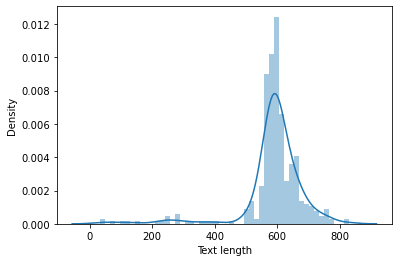


Description of Sentence length :
Count: 7593
Sum: 246996
Min: 2
Mean: 32.52943500592651
Max: 251


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


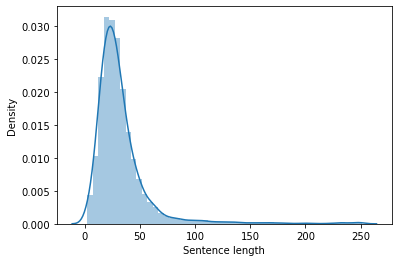



Description of mentions
Total: 28751
EnvironmentalIssues : 6704
Date : 2062
Organisation : 10256
CommitmentLevel : 3127
Location : 1397
CoalActivity : 75
SocialIssues : 4986
SocialOfficialTexts : 144


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


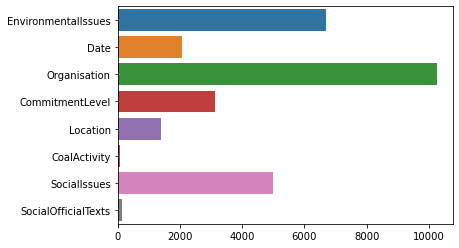

Entity encoding: {'None': 0, 'EnvironmentalIssues': 1, 'Date': 2, 'Organisation': 3, 'CommitmentLevel': 4, 'Location': 5, 'CoalActivity': 6, 'SocialIssues': 7, 'SocialOfficialTexts': 8}

Description of relations
Total: 5864
Makes : 2022
Of : 2901
IsRelatedTo : 774
HasActivity : 40
Recognizes : 111
In : 13
IsInvolvedIn : 3


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


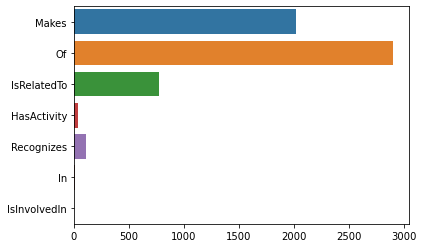

Relation encoding: {'None': 0, 'Makes': 1, 'Of': 2, 'IsRelatedTo': 3, 'HasActivity': 4, 'Recognizes': 5, 'In': 6, 'IsInvolvedIn': 7}

Token count: 282322
Entity token count: 63292
Unknown token count: 0
Unknown entity token count: 0

Relation count: 5864
Reverse relation count: 2028
Cross sentence count: 0



In [42]:
describe_data()